In [44]:
from qiskit import QuantumCircuit, transpile
# from qiskit.providers.aer import QasmSimulator
# from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit_aer import AerSimulator, Aer
from qiskit.providers.fake_provider import FakeProvider, FakeManila, FakeToronto, FakeJakartaV2
from qiskit_aer.noise import NoiseModel
import qiskit.quantum_info as qi
import qiskit as qiskit

import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import sys
from datetime import date
import pathlib
import inspect
import time
import glob
from copy import deepcopy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('..'))
module_path = os.path.abspath(os.path.join(module_path, '..')) # qrc_surrogate
sys.path.append(module_path)
plot_path = f'{module_path}/plots/plots_reactor'


from src.feedforward import QExtremeLearningMachine, CPolynomialFeedforward
from src.rewinding import QRewindingRC, QRewindingStatevectorRC
from src.data import DataSource
import experiments.plotting.plotting as plotting
from experiments.simulating.sweeps_paras import print_best_paras, get_paras

sns.set_style("whitegrid")
palette = 'muted' # muted deep colorblind dark
colors = sns.color_palette(palette).as_hex() 
sns.set_palette(sns.color_palette(palette))
# magma, rocket, viridis, YlOrBr, crest, flare
colors_sequential = sns.color_palette("viridis", n_colors=7)
colors_sequential_secondary = sns.color_palette("YlOrBr", n_colors=7)

# Plot results of logged experiments

Whenever we run a model, the parameters and results get logged in a dataframe.
In this notebook we access this dataframe and plot whatever we are interested in.

For each plot, we usually select some 'base settings' we are interested in (model_of_interest, data_of_interest), and then vary a single paramter that we plot.

In [45]:
# QExtremeLearningMachine QRewindingStatevectorRC
model_type = QRewindingStatevectorRC # <- select a model

# fullnames = glob.glob(f'{module_path}/experiments/results/' + r"*.parquet")
# print(f'Saved models:\n {fullnames}')

model = model_type()
print(f'Set model:\n {model.model_name}')
f = f'{module_path}/experiments/results/{model.model_name}.parquet'
df = pd.read_parquet(f)

# useful lists
passable_model_params = inspect.getfullargspec(model.__init__).args[1:]
passable_data_params = inspect.getfullargspec(DataSource().__init__).args[1:]
metrics = ['corr_train', 'corr_val', 'mse_train', 'mse_val', 'mape_train', 'mape_val', 'nrmse_train', 'nrmse_val', 'traintime']

print(f'Metrics in the dataframe:\n {passable_model_params}')

# metric we want to plot
ymetric = 'mape_val'
ymetric_train = ymetric.split('_')[0] + '_train'

# errorbars
errorbar_type = 'sd' # standard deviation
# errorbar_type = ('ci', 95) # confidence interval, 95%


# Choose the parameters you want to plot
# Print the model parameters with the best validation score
# print_best_paras(experiment=experiment)

model_of_interest, data_of_interest = get_paras(model)

# data_of_interest.pop('nepisodes')

# model_of_interest[xaxis_column] = 0

print('Selected model parameters:\n', model_of_interest)
print('Selected data parameters:\n', data_of_interest)

df = pd.read_parquet(f)

fname_data = 'reactor'

Set model:
 rewinding_statevector_rc
Metrics in the dataframe:
 ['sim_sampling', 'use_partial_meas', 'reset_instead_meas', 'lookback', 'add_y_to_input', 'restarting', 'mend', 'set_past_y_to_0', 'use_true_y_in_val', 'washout', 'preloading', 'mtype', 'minc', 'nmeas', 'reseti', 'resetm', 'lookback_max', 'rseed', 'log', 'add_x_as_feature', 'nyfuture', 'delete_future_y', 'fitter', 'regression_model', 'regression_alpha', 'regression_l1', 'poly_degree', 'nqubits', 'qctype', 'qinit', 'nlayers', 'ftype', 'enctype', 'encaxes', 'nenccopies', 'encangle', 'measaxes', 'shots', 'ising_t', 'ising_jmax', 'ising_h', 'ising_wmax', 'ising_random', 'ising_jpositive', 'ising_wpositive', 'sim', 't1', 'sim_method', 'sim_precision']
Selected model parameters:
 {'qctype': 'ising', 'nyfuture': 1, 'lookback': 1, 'lookback_max': True, 'add_y_to_input': True, 'use_true_y_in_val': False, 'use_partial_meas': False, 'reset_instead_meas': False, 'reseti': True, 'resetm': True, 'measaxes': 'zyx', 'ising_t': 1.0, 'ising_

# Examples

In [46]:
# data = DataSource(**data_of_interest)
# rnn = model_type(**model_of_interest)
# rnn.run(data)

# fig = rnn.plot_val(nepisodes=3)

# fig.savefig(f'{plot_path}/{model.model_name}_{fname_data}.svg')

# fig = rnn.plot_worst_val_episodes(nepisodes=3)
# fig.savefig(f'{plot_path}/{model.model_name}_{fname_data}_worst.svg')

# fig = rnn.plot_best_val_episodes(nepisodes=3)
# fig.savefig(f'{plot_path}/{model.model_name}_{fname_data}_best.svg')

In [47]:
# # Classical benchmark

# data = DataSource(**data_of_interest)
# baseline = CPolynomialFeedforward()
# baseline.run(data)

# fig = baseline.plot_val(nepisodes=3)

# fig.savefig(f'{plot_path}/{baseline.model_name}_{fname_data}.svg')

## rseed variance

### Variance for different seeds for data

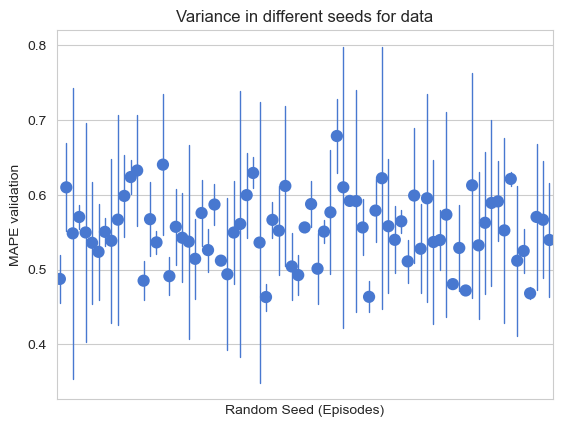

In [48]:
xaxis_column = 'rseed_data'

hue_columns = ['nqubits']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    # keep_columns = ['rseed'],
    # change_moi = {'shots': 8192},
    cutoff = 50,
)

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    # label = f'{qctype}',
    hue=hue,
    dodge=.1,
    linestyles='None',
    errorbar = errorbar_type, 
    errwidth=1,
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Variance in different seeds for data')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ticks = range(len(df[xaxis_column].unique()))
labels = df[xaxis_column].unique()
ticks, labels = plotting.sparse_ticks(ticks, labels, 10)
# ax.set_xticks(ticks, labels)
ax.set_xticks([])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Random Seed (Episodes)')
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')
# plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

### Variance for different seeds for QC

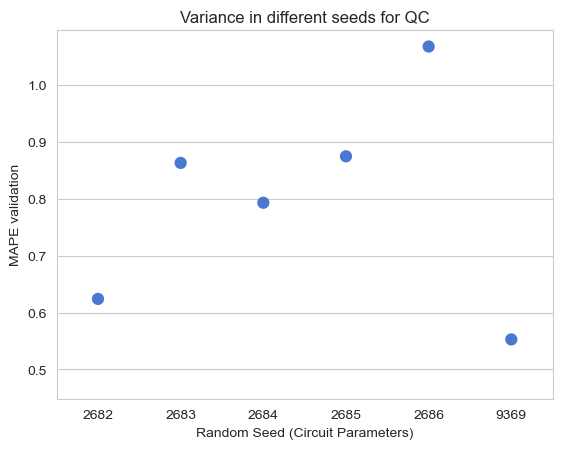

In [49]:
xaxis_column = 'rseed'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['measaxes']
hue_columns = ['nqubits']
hue_columns = ['sim']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    # cutoff=30,
)



ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    # label = f'{qctype}',
    hue=hue,
    # dodge = .1,
    linestyles='None',
    errorbar = errorbar_type, 
    errwidth=0,
    # errwidth=1,
)

ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Variance in different seeds for QC')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
# ax.set_xticks([''])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Random Seed (Circuit Parameters)')
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

## expectation values as features (ftype)

and how many axis to measure

[1 2 3 4 5]


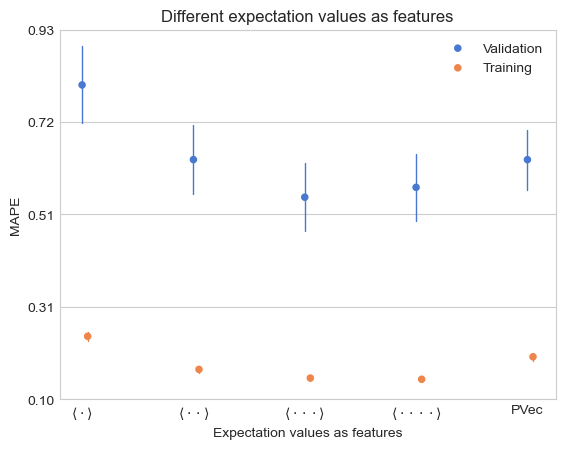

In [50]:
xaxis_column = 'ftype'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['qctype']
hue_columns = ['nqubits']
hue_columns = ['measaxes']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    change_moi = {'sim_sampling': 'multinomial'},
    keep_columns = ['rseed_data'],
    cutoff = 30,
)


df.loc[df['ftype'] == 0, 'ftype'] = 5
df = df.sort_values(by=[xaxis_column])

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    # label = f'{qctype}',
    hue=hue,
    # linestyles=['-', '-', '--', '--', ':', ':', '-.', '-.'], # for different ftypes
    # markers=['x', 'x', '.', '.', '^', '^', 'o', 'o'], # for different ftypes
    linestyles='none',
    dodge = .1,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
    label='Validation',
    xpos=True,
)

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric_train, data = df, 
    # label = f'{qctype}',
    hue=hue,
    # linestyles=['-', '-', '--', '--', ':', ':', '-.', '-.'], # for different ftypes
    # markers=['x', 'x', '.', '.', '^', '^', 'o', 'o'], # for different ftypes
    color=colors[1],
    linestyles='none',
    dodge = .1,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
    label='Training',
    ax=ax,
    xpos=True,
    xoffset=.05,
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Different expectation values as features')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
print(df[xaxis_column].unique())
ax.set_xticks(
    df[xaxis_column].unique(),
    [
        r'$\langle ' + r''.join([r' \cdot ' for _ in range(int(ft))]) + r' \rangle $' 
        if int(ft) > 0 and int(ft) < 5 else 'PVec'
        for ft in df[xaxis_column].unique()
    ]
)
ax.set_ylabel(ymetric.split('_')[0].upper())
ax.set_xlabel('Expectation values as features')


legend = plt.legend()
legend.get_frame().set_linewidth(0.0)
# aligned y ticks
# ax2.yaxis.grid(False)
ax.set_yticks(
    np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5),
    [f'{_v:.2f}' for _v in np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5)],
)
ax.tick_params(width=0, length=0)

ax.autoscale()

plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

[1 2 3 4 5]


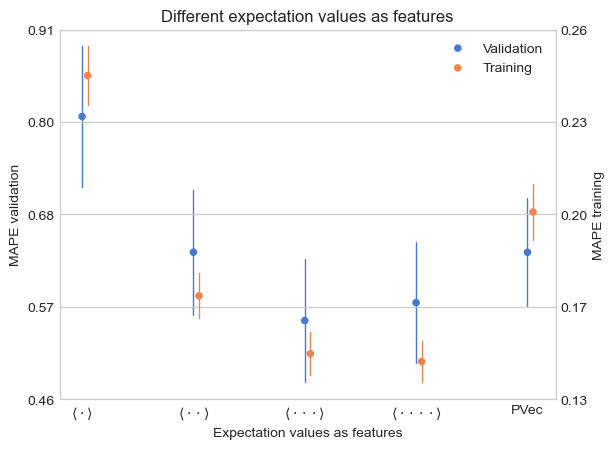

In [51]:
xaxis_column = 'ftype'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['qctype']
hue_columns = ['nqubits']
hue_columns = ['measaxes']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    change_moi = {'sim_sampling': 'multinomial'},
    keep_columns = ['rseed_data'],
    cutoff = 30,
)


df.loc[df['ftype'] == 0, 'ftype'] = 5
df = df.sort_values(by=[xaxis_column])

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    # label = f'{qctype}',
    hue=hue,
    # linestyles=['-', '-', '--', '--', ':', ':', '-.', '-.'], # for different ftypes
    # markers=['x', 'x', '.', '.', '^', '^', 'o', 'o'], # for different ftypes
    linestyles='none',
    dodge = .1,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
    label='Validation',
    xpos=True,
)

ax2 = ax.twinx()
ax2 = plotting.better_pointplot(
    x = xaxis_column, y = ymetric_train, data = df, 
    # label = f'{qctype}',
    hue=hue,
    # linestyles=['-', '-', '--', '--', ':', ':', '-.', '-.'], # for different ftypes
    # markers=['x', 'x', '.', '.', '^', '^', 'o', 'o'], # for different ftypes
    color=colors[1],
    linestyles='none',
    dodge = .1,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
    label='Training',
    ax=ax2,
    xpos=True,
    xoffset=.05,
)
ax2.set_ylabel(ymetric.split('_')[0].upper() + ' training')

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Different expectation values as features')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
print(df[xaxis_column].unique())
ax.set_xticks(
    df[xaxis_column].unique(),
    [
        r'$\langle ' + r''.join([r' \cdot ' for _ in range(int(ft))]) + r' \rangle $' 
        if int(ft) > 0 and int(ft) < 5 else 'PVec'
        for ft in df[xaxis_column].unique()
    ]
)
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Expectation values as features')

h, l = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
legend = plt.legend(h + h2, l + l2)
legend.get_frame().set_linewidth(0.0)
# aligned y ticks
# ax2.yaxis.grid(False)
ax.set_yticks(
    np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5),
    [f'{_v:.2f}' for _v in np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5)],
)
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 5),
    [f'{_v:.2f}' for _v in np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 5)],
)
ax.tick_params(width=0, length=0)
ax2.tick_params(width=0, length=0)

ax.autoscale()

# plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

[1 2 3 4 5]


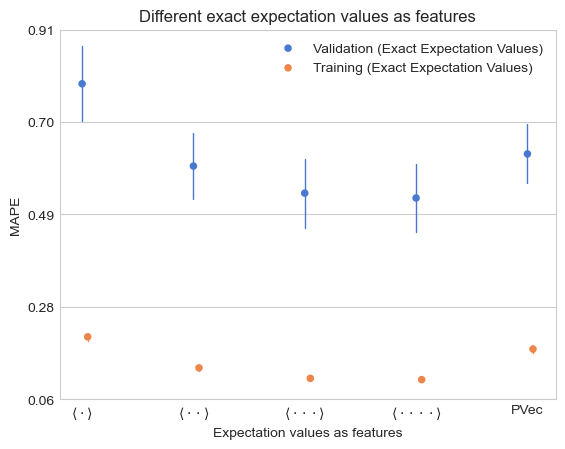

In [52]:
xaxis_column = 'ftype'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['qctype']
hue_columns = ['nqubits']
hue_columns = ['measaxes']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    change_moi = {'sim_sampling': 'naive'},
    keep_columns = ['rseed_data'],
    cutoff = 30,
)


df.loc[df['ftype'] == 0, 'ftype'] = 5
df = df.sort_values(by=[xaxis_column])

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    # label = f'{qctype}',
    hue=hue,
    # linestyles=['-', '-', '--', '--', ':', ':', '-.', '-.'], # for different ftypes
    # markers=['x', 'x', '.', '.', '^', '^', 'o', 'o'], # for different ftypes
    linestyles='none',
    dodge = .1,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
    label='Validation (Exact Expectation Values)',
    xpos=True,
    # ax=ax,
)

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric_train, data = df, 
    # label = f'{qctype}',
    hue=hue,
    # linestyles=['-', '-', '--', '--', ':', ':', '-.', '-.'], # for different ftypes
    # markers=['x', 'x', '.', '.', '^', '^', 'o', 'o'], # for different ftypes
    color=colors[1],
    linestyles='none',
    dodge = .1,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
    label='Training (Exact Expectation Values)',
    ax=ax,
    xpos=True,
    xoffset=.05,
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Different exact expectation values as features')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
print(df[xaxis_column].unique())
ax.set_xticks(
    df[xaxis_column].unique(),
    [
        r'$\langle ' + r''.join([r' \cdot ' for _ in range(int(ft))]) + r' \rangle $' 
        if int(ft) > 0 and int(ft) < 5 else 'PVec'
        for ft in df[xaxis_column].unique()
    ]
)
ax.set_ylabel(ymetric.split('_')[0].upper())
ax.set_xlabel('Expectation values as features')


legend = plt.legend()
legend.get_frame().set_linewidth(0.0)
# aligned y ticks
# ax2.yaxis.grid(False)
ax.set_yticks(
    np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5),
    [f'{_v:.2f}' for _v in np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5)],
)
ax.tick_params(width=0, length=0)

ax.autoscale()

# plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}_exact.svg')
plt.show()

[1 2 3 4 5]


/Users/andreas-burger/RLCode/quantum-reinforcement-learning/qrc_surrogate/experiments/plotting/plotting.py:156: UserWarning: You passed a edgecolor/edgecolors ([(0.2823529411764706, 0.47058823529411764, 0.8156862745098039), (0.2823529411764706, 0.47058823529411764, 0.8156862745098039), (0.2823529411764706, 0.47058823529411764, 0.8156862745098039), (0.2823529411764706, 0.47058823529411764, 0.8156862745098039), (0.2823529411764706, 0.47058823529411764, 0.8156862745098039)]) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/Users/andreas-burger/RLCode/quantum-reinforcement-learning/qrc_surrogate/experiments/plotting/plotting.py:156: UserWarning: You passed a edgecolor/edgecolors ([(0.9333333333333333, 0.5215686274509804, 0.2901960784313726), (0.9333333333333333, 0.5215686274509804, 0.2901960784313726), (0.9333333333333333, 0.5215686274509804, 0.2901960784313726), (0.9333333333333333, 

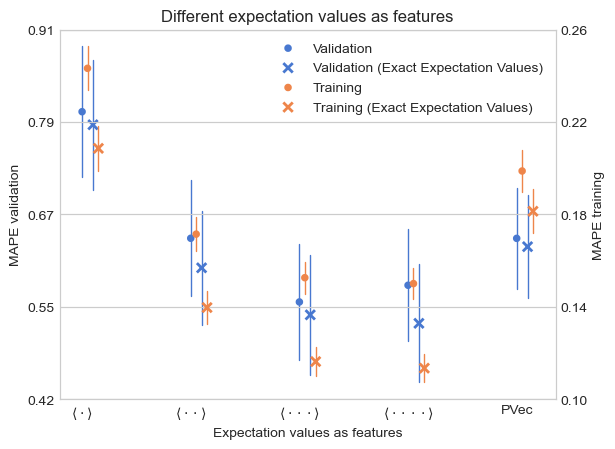

In [53]:
xaxis_column = 'ftype'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['qctype']
hue_columns = ['nqubits']
hue_columns = ['measaxes']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    change_moi = {'sim_sampling': 'multinomial'},
    keep_columns = ['rseed_data'],
    cutoff = 30,
)
df.loc[df['ftype'] == 0, 'ftype'] = 5
df = df.sort_values(by=[xaxis_column])

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    # label = f'{qctype}',
    hue=hue,
    # linestyles=['-', '-', '--', '--', ':', ':', '-.', '-.'], # for different ftypes
    # markers=['x', 'x', '.', '.', '^', '^', 'o', 'o'], # for different ftypes
    linestyles='none',
    dodge = .1,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
    label='Validation',
    xpos=True,
)

ax2 = ax.twinx()
ax2 = plotting.better_pointplot(
    x = xaxis_column, y = ymetric_train, data = df, 
    # label = f'{qctype}',
    hue=hue,
    # linestyles=['-', '-', '--', '--', ':', ':', '-.', '-.'], # for different ftypes
    # markers=['x', 'x', '.', '.', '^', '^', 'o', 'o'], # for different ftypes
    color=colors[1],
    linestyles='none',
    dodge = .1,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
    label='Training',
    ax=ax2,
    xpos=True,
    xoffset=.05,
)
ax2.set_ylabel(ymetric.split('_')[0].upper() + ' training')

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    change_moi = {'sim_sampling': 'naive'},
    keep_columns = ['rseed_data'],
    cutoff = 30,
)
df.loc[df['ftype'] == 0, 'ftype'] = 5
df = df.sort_values(by=[xaxis_column])

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    # label = f'{qctype}',
    hue=hue,
    # linestyles=['-', '-', '--', '--', ':', ':', '-.', '-.'], # for different ftypes
    # markers=['x', 'x', '.', '.', '^', '^', 'o', 'o'], # for different ftypes
    linestyles='none',
    color=colors[0],
    dodge = .1,
    errorbar = errorbar_type, 
    markers='x',
    errwidth=1,
    label='Validation (Exact Expectation Values)',
    xpos=True,
    ax=ax,
    xoffset=.1,
)

ax2 = plotting.better_pointplot(
    x = xaxis_column, y = ymetric_train, data = df, 
    # label = f'{qctype}',
    hue=hue,
    # linestyles=['-', '-', '--', '--', ':', ':', '-.', '-.'], # for different ftypes
    # markers=['x', 'x', '.', '.', '^', '^', 'o', 'o'], # for different ftypes
    color=colors[1],
    linestyles='none',
    dodge = .1,
    errorbar = errorbar_type, 
    markers='x',
    errwidth=1,
    label='Training (Exact Expectation Values)',
    ax=ax2,
    xpos=True,
    xoffset=.15,
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Different expectation values as features')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
print(df[xaxis_column].unique())
ax.set_xticks(
    df[xaxis_column].unique(),
    [
        r'$\langle ' + r''.join([r' \cdot ' for _ in range(int(ft))]) + r' \rangle $' 
        if int(ft) > 0 and int(ft) < 5 else 'PVec'
        for ft in df[xaxis_column].unique()
    ]
)
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax2.set_ylabel(ymetric.split('_')[0].upper() + ' training')
ax.set_xlabel('Expectation values as features')

h, l = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
legend = plt.legend(h + h2, l + l2)
legend.get_frame().set_linewidth(0.0)
# aligned y ticks
# ax2.yaxis.grid(False)
ax.set_yticks(
    np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5),
    [f'{_v:.2f}' for _v in np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5)],
)
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 5),
    [f'{_v:.2f}' for _v in np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 5)],
)
ax.tick_params(width=0, length=0)
ax2.tick_params(width=0, length=0)

ax.autoscale()

# plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}_exact.svg')
plt.show()

[1 2 3 4 5]


/Users/andreas-burger/RLCode/quantum-reinforcement-learning/qrc_surrogate/experiments/plotting/plotting.py:156: UserWarning: You passed a edgecolor/edgecolors ([(0.2823529411764706, 0.47058823529411764, 0.8156862745098039), (0.2823529411764706, 0.47058823529411764, 0.8156862745098039), (0.2823529411764706, 0.47058823529411764, 0.8156862745098039), (0.2823529411764706, 0.47058823529411764, 0.8156862745098039), (0.2823529411764706, 0.47058823529411764, 0.8156862745098039)]) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,
/Users/andreas-burger/RLCode/quantum-reinforcement-learning/qrc_surrogate/experiments/plotting/plotting.py:156: UserWarning: You passed a edgecolor/edgecolors ([(0.9333333333333333, 0.5215686274509804, 0.2901960784313726), (0.9333333333333333, 0.5215686274509804, 0.2901960784313726), (0.9333333333333333, 0.5215686274509804, 0.2901960784313726), (0.9333333333333333, 

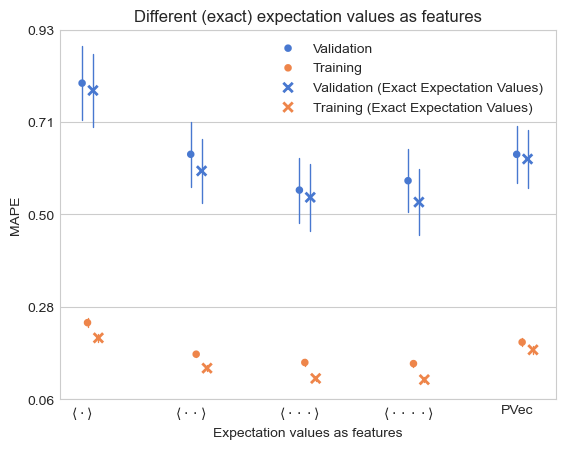

In [54]:
xaxis_column = 'ftype'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['qctype']
hue_columns = ['nqubits']
hue_columns = ['measaxes']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    change_moi = {'sim_sampling': 'multinomial'},
    keep_columns = ['rseed_data'],
    cutoff = 30,
)
df.loc[df['ftype'] == 0, 'ftype'] = 5
df = df.sort_values(by=[xaxis_column])

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    # label = f'{qctype}',
    hue=hue,
    # linestyles=['-', '-', '--', '--', ':', ':', '-.', '-.'], # for different ftypes
    # markers=['x', 'x', '.', '.', '^', '^', 'o', 'o'], # for different ftypes
    linestyles='none',
    dodge = .1,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
    label='Validation',
    xpos=True,
)

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric_train, data = df, 
    # label = f'{qctype}',
    hue=hue,
    # linestyles=['-', '-', '--', '--', ':', ':', '-.', '-.'], # for different ftypes
    # markers=['x', 'x', '.', '.', '^', '^', 'o', 'o'], # for different ftypes
    color=colors[1],
    linestyles='none',
    dodge = .1,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
    label='Training',
    ax=ax,
    xpos=True,
    xoffset=.05,
)

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    change_moi = {'sim_sampling': 'naive'},
    keep_columns = ['rseed_data'],
    cutoff = 30,
)
df.loc[df['ftype'] == 0, 'ftype'] = 5
df = df.sort_values(by=[xaxis_column])

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    # label = f'{qctype}',
    hue=hue,
    # linestyles=['-', '-', '--', '--', ':', ':', '-.', '-.'], # for different ftypes
    # markers=['x', 'x', '.', '.', '^', '^', 'o', 'o'], # for different ftypes
    linestyles='none',
    color=colors[0],
    dodge = .1,
    errorbar = errorbar_type, 
    markers='x',
    errwidth=1,
    label='Validation (Exact Expectation Values)',
    xpos=True,
    ax=ax,
    xoffset=.1,
)

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric_train, data = df, 
    # label = f'{qctype}',
    hue=hue,
    # linestyles=['-', '-', '--', '--', ':', ':', '-.', '-.'], # for different ftypes
    # markers=['x', 'x', '.', '.', '^', '^', 'o', 'o'], # for different ftypes
    color=colors[1],
    linestyles='none',
    dodge = .1,
    errorbar = errorbar_type, 
    markers='x',
    errwidth=1,
    label='Training (Exact Expectation Values)',
    ax=ax,
    xpos=True,
    xoffset=.15,
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Different (exact) expectation values as features')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
print(df[xaxis_column].unique())
ax.set_xticks(
    df[xaxis_column].unique(),
    [
        r'$\langle ' + r''.join([r' \cdot ' for _ in range(int(ft))]) + r' \rangle $' 
        if int(ft) > 0 and int(ft) < 5 else 'PVec'
        for ft in df[xaxis_column].unique()
    ]
)
ax.set_ylabel(ymetric.split('_')[0].upper())
ax.set_xlabel('Expectation values as features')

legend = plt.legend()
legend.get_frame().set_linewidth(0.0)
ax.set_yticks(
    np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5),
    [f'{_v:.2f}' for _v in np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5)],
)
ax.tick_params(width=0, length=0)

ax.autoscale()

plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}_exact.svg')
plt.show()

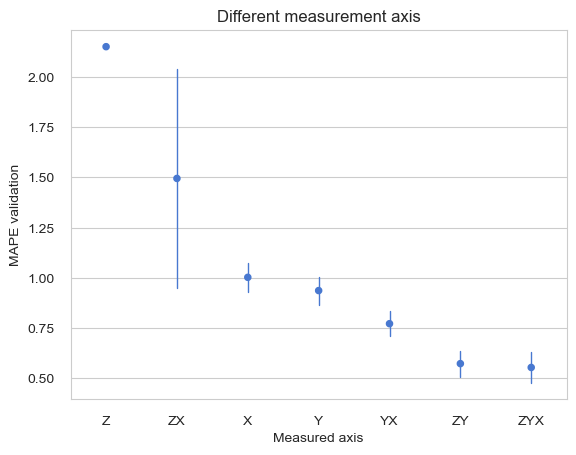

In [55]:
xaxis_column = 'measaxes'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['qctype']
hue_columns = ['nqubits']
hue_columns = ['ftype']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    change_moi = {'sim': 'aer_simulator'}, 
    keep_columns = ['rseed_data'],
    # cutoff = 30,
    average = True,
    # verbose=True,
)
    
# sel = [p for p in passable_model_params + passable_data_params if p not in hue_columns]


df = df.sort_values('measaxes', )
sortcol = 'measaxes'
sort_list = ['z', 'zx', 'x', 'y', 'yx', 'zy', 'zyx']
df[sortcol] = df[sortcol].astype("category")
df[sortcol] = df[sortcol].cat.set_categories(sort_list)
df = df.sort_values([sortcol])

plot_max = None
# plot_max = 2
if plot_max is not None:
    df.loc[df[ymetric] > plot_max, ymetric] = plot_max

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    # label = f'{qctype}',
    hue=hue,
    linestyles='none',
    # linestyles='-',
    dodge = .3,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
    label='Validation',
)

if plot_max is not None:
    ax.set_ylim(ax.get_ylim()[0], plot_max)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Different measurement axis')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_xticks(ax.get_xticks(), [_f.get_text().upper() for _f in ax.get_xticklabels()])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Measured axis')
ax.tick_params(
    axis='both', which='both', 
    size=8,
    # labelsize=25,
)
# legend = plt.legend()
# legend.get_frame().set_linewidth(0.0)

plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

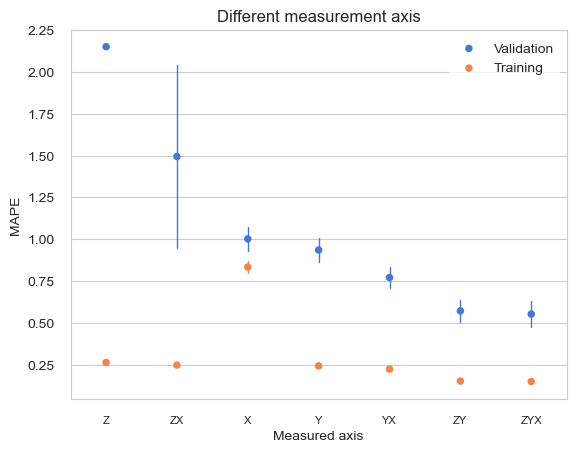

In [56]:
xaxis_column = 'measaxes'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['qctype']
hue_columns = ['nqubits']
hue_columns = ['ftype']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    change_moi = {'sim': 'aer_simulator'}, 
    keep_columns = ['rseed_data'],
    # cutoff = 30,
    average = True,
    # verbose=True,
)
    
# sel = [p for p in passable_model_params + passable_data_params if p not in hue_columns]


df = df.sort_values('measaxes', )
sortcol = 'measaxes'
sort_list = ['z', 'zx', 'x', 'y', 'yx', 'zy', 'zyx']
df[sortcol] = df[sortcol].astype("category")
df[sortcol] = df[sortcol].cat.set_categories(sort_list)
df = df.sort_values([sortcol])

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    # label = f'{qctype}',
    hue=hue,
    linestyles='none',
    # linestyles='-',
    dodge = .3,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
    label='Validation',
)

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric_train, data = df, 
    # label = f'{qctype}',
    hue=hue,
    color=colors[1],
    linestyles='none',
    # linestyles='-',
    dodge = .3,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
    ax=ax,
    label='Training',
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Different measurement axis')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_xticks(ax.get_xticks(), [_f.get_text().upper() for _f in ax.get_xticklabels()], size=8)
ax.tick_params(
    axis='both', which='both', 
    size=8,
    # labelsize=25,
)
ax.set_ylabel(ymetric.split('_')[0].upper())
ax.set_xlabel('Measured axis')

legend = plt.legend()
legend.get_frame().set_linewidth(0.0)

plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}_trainval.svg')
plt.show()

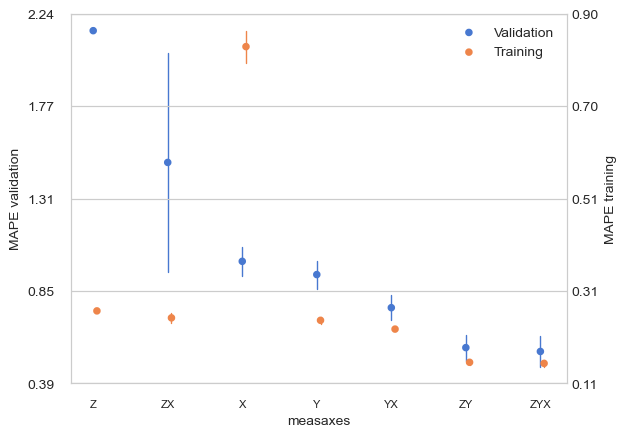

In [57]:
xaxis_column = 'measaxes'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['qctype']
hue_columns = ['nqubits']
hue_columns = ['ftype']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    change_moi = {'sim': 'aer_simulator'}, 
    keep_columns = ['rseed_data'],
    # cutoff = 30,
    average = True,
    # verbose=True,
)
    
# sel = [p for p in passable_model_params + passable_data_params if p not in hue_columns]


df = df.sort_values('measaxes', )
sortcol = 'measaxes'
sort_list = ['z', 'zx', 'x', 'y', 'yx', 'zy', 'zyx']
df[sortcol] = df[sortcol].astype("category")
df[sortcol] = df[sortcol].cat.set_categories(sort_list)
df = df.sort_values([sortcol])
df[sortcol] = df[sortcol].astype(str)
# df = df.sort_values([ymetric])

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    # label = f'{qctype}',
    hue=hue,
    linestyles='none',
    # linestyles='-',
    dodge = .3,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
    label='Validation',
    # xpos=True,
)

ax2 = ax.twinx()
ax2 = plotting.better_pointplot(
    x = xaxis_column, y = ymetric_train, data = df, 
    # label = f'{qctype}',
    hue=hue,
    color=colors[1],
    linestyles='none',
    # linestyles='-',
    dodge = .3,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
    ax=ax2,
    label='Training',
    # xpos=True,
    xoffset=.05,
)
ax2.set_ylabel(ymetric.split('_')[0].upper() + ' training')
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.autoscale()
ax.set_xticks(ax.get_xticks(), [_f.get_text().upper() for _f in ax.get_xticklabels()], size=8)

h, l = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
legend = plt.legend(h + h2, l + l2)
legend.get_frame().set_linewidth(0.0)
# aligned y ticks
# ax2.yaxis.grid(False)
ax.set_yticks(
    np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5),
    [f'{_v:.2f}' for _v in np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5)],
)
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 5),
    [f'{_v:.2f}' for _v in np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 5)],
)
ax.tick_params(width=0, length=0)
ax2.tick_params(width=0, length=0)
ax.tick_params(
    axis='both', which='both', 
    size=8,
    # labelsize=25,
)

# plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}_trainval.svg')
plt.show()

## number of predicted steps (nyfuture)

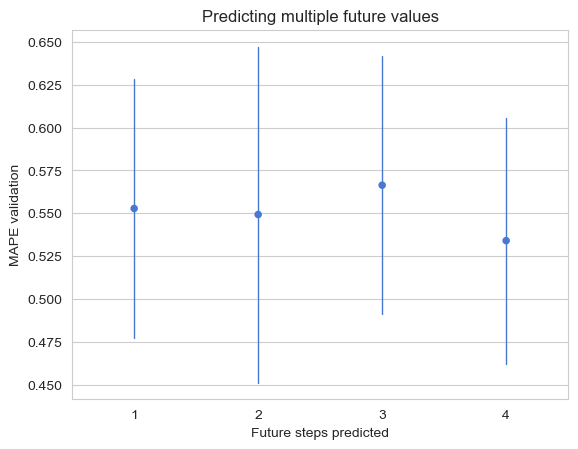

In [58]:
xaxis_column = 'nyfuture'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['ftype', 'measaxes']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    change_moi = {'ftype': 3}, 
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    average = True,
    # cutoff = 30,
)   



ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    linestyles='none',
    hue=hue,
    dodge=.1,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
)

ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Predicting multiple future values')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
# ax.set_xticks([''])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Future steps predicted')
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

# Nqubits

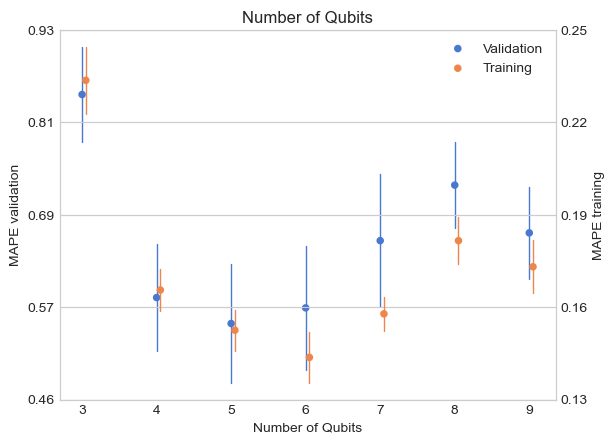

In [59]:
xaxis_column = 'nqubits'

hue_columns = ['measaxes']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    change_moi = {'ftype': 3},
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    # cutoff = 30,
)

df[xaxis_column] = df[xaxis_column].astype(float)




ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    hue=hue,
    dodge=.2,
    errwidth=1.,
    errorbar = errorbar_type, 
    linestyles='none',
    markers = '.',
    label='Validation',
    xpos=True,
)

ax2 = ax.twinx()
ax2 = plotting.better_pointplot(
    x = xaxis_column, y = ymetric_train, data = df, 
    hue=hue,
    color=colors[1],
    dodge=.2,
    errwidth=1.,
    errorbar = errorbar_type, 
    linestyles='none',
    markers = '.',
    label='Training',
    ax=ax2,
    xpos=True,
    xoffset=.05,
)
ax2.set_ylabel(ymetric.split('_')[0].upper() + ' training')

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Number of Qubits')

ax.autoscale()
ax.set_xticks(
    df[xaxis_column].unique(),
    [f'{int(_v)}' for _v in df[xaxis_column].unique()],
)

h, l = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
legend = plt.legend(h + h2, l + l2)
legend.get_frame().set_linewidth(0.0)
# aligned y ticks
# ax2.yaxis.grid(False)
ax.set_yticks(
    np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5),
    [f'{_v:.2f}' for _v in np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5)],
)
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 5),
    [f'{_v:.2f}' for _v in np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 5)],
)
ax.tick_params(width=0, length=0)
ax2.tick_params(width=0, length=0)

ax.set_title('Number of Qubits')
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

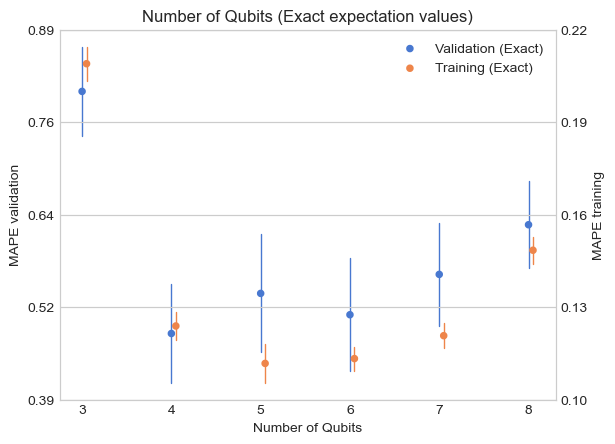

In [60]:
xaxis_column = 'nqubits'

hue_columns = ['measaxes']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    change_moi = {'sim_sampling': 'naive'},
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    # cutoff = 30,
)

df[xaxis_column] = df[xaxis_column].astype(float)




ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    hue=hue,
    dodge=.2,
    errwidth=1.,
    errorbar = errorbar_type, 
    linestyles='none',
    markers = '.',
    label='Validation (Exact)',
    xpos=True,
)

ax2 = ax.twinx()
ax2 = plotting.better_pointplot(
    x = xaxis_column, y = ymetric_train, data = df, 
    hue=hue,
    color=colors[1],
    dodge=.2,
    errwidth=1.,
    errorbar = errorbar_type, 
    linestyles='none',
    markers = '.',
    label='Training (Exact)',
    ax=ax2,
    xpos=True,
    xoffset=.05,
)
ax2.set_ylabel(ymetric.split('_')[0].upper() + ' training')

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Number of Qubits')

ax.autoscale()
ax.set_xticks(
    df[xaxis_column].unique(),
    [f'{int(_v)}' for _v in df[xaxis_column].unique()],
)

h, l = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
legend = plt.legend(h + h2, l + l2)
legend.get_frame().set_linewidth(0.0)
# aligned y ticks
# ax2.yaxis.grid(False)
ax.set_yticks(
    np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5),
    [f'{_v:.2f}' for _v in np.linspace(ax.get_ybound()[0], ax.get_ybound()[1], 5)],
)
ax2.set_yticks(
    np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 5),
    [f'{_v:.2f}' for _v in np.linspace(ax2.get_ybound()[0], ax2.get_ybound()[1], 5)],
)
ax.tick_params(width=0, length=0)
ax2.tick_params(width=0, length=0)

ax.set_title('Number of Qubits (Exact expectation values)')
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}_exact.svg')
plt.show()

# Circuit (unitary) type

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


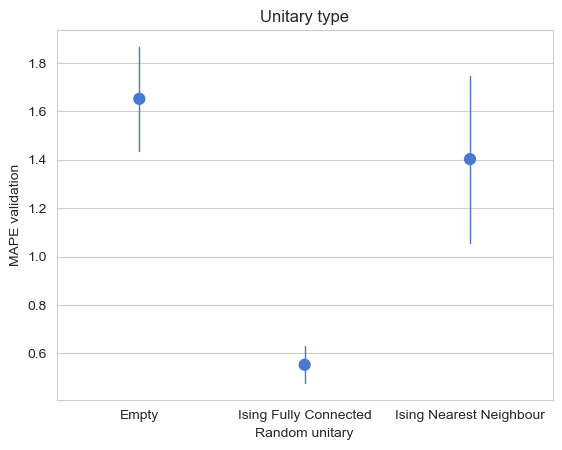

In [61]:
xaxis_column = 'qctype'

hue_columns = ['measaxes']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    # change_moi = {'ftype': 0},
    change_moi = {'ftype': 3},
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    # cutoff = 30,
)




ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    hue=hue,
    dodge=.2,
    errwidth=1.,
    errorbar = errorbar_type, 
    linestyles='none'
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_xticks(
    [*range(len(df[xaxis_column].unique()))],
    ['Empty', 'Ising Fully Connected', 'Ising Nearest Neighbour']
)
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Random unitary')
legend = ax.legend(frameon=True)
legend.get_frame().set_linewidth(0.0)
ax.set_title('Unitary type')
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

# add_x_as_feature

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


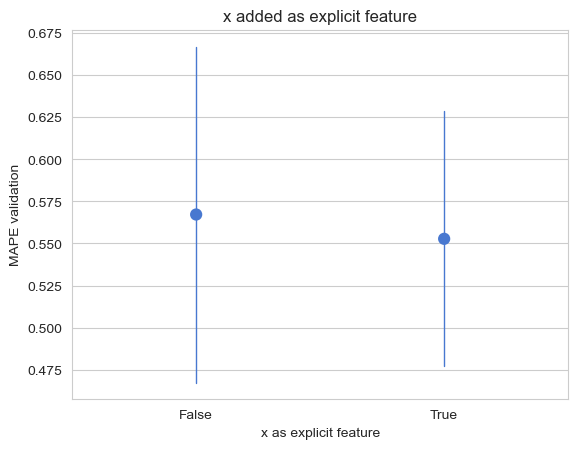

In [62]:
xaxis_column = 'add_x_as_feature'

hue_columns = ['measaxes']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    change_moi = {'ftype': 3},
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    # cutoff = 30,
)




ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    hue=hue,
    dodge=.2,
    errwidth=1.,
    errorbar = errorbar_type, 
    linestyles='none'
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
# ax.set_xticks([''])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('x as explicit feature')
legend = ax.legend(frameon=True)
legend.get_frame().set_linewidth(0.0)
ax.set_title('x added as explicit feature')
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

# Ising

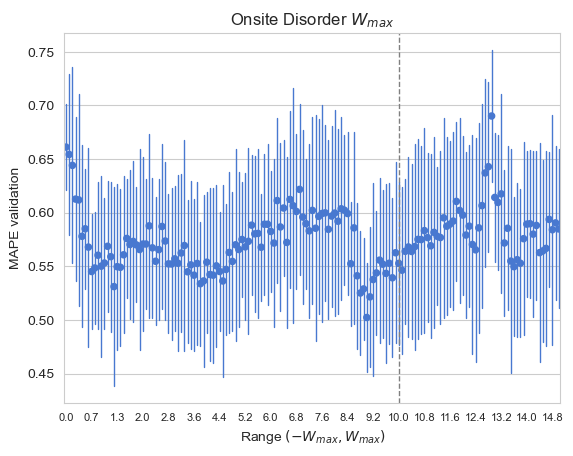

In [63]:
xaxis_column = 'ising_wmax'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['ftype', 'measaxes']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    # change_moi = {'ftype': 0}, 
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    # cutoff = 30,
)

df[xaxis_column] = df[xaxis_column].astype(float)
    



ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    linestyles='none',
    hue=hue,
    dodge=.1,
    errorbar = errorbar_type, 
    markers='.',
    errwidth=1,
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ticks = [*range(len(df[xaxis_column].unique()))]
labels = [f'{_c:.1f}' for _c in df[xaxis_column].unique()]
xpos = labels.index('10.0')
ticks, labels = plotting.sparse_ticks(ticks, labels, 20)
ax.set_xticks(ticks, labels, size=8)

ax.set_ylim(ax.get_ylim())
ax.axvline(xpos, color='gray', linestyle='--', linewidth=1)

ax.set_title(r'Onsite Disorder $W_{max}$')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
# ax.set_xticks([''])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel(r'Range $(- W_{max}, W_{max})$')
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

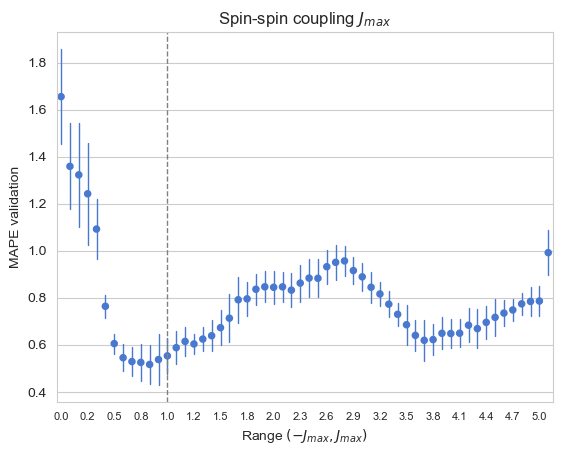

In [64]:
xaxis_column = 'ising_jmax'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['ftype', 'measaxes']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    # change_moi = {'ftype': 0}, 
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    # cutoff = 30,
)

df[xaxis_column] = df[xaxis_column].astype(float)



ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    linestyles='none',
    hue=hue,
    dodge=.1,
    errorbar = errorbar_type, 
    errwidth=1,
    markers='.',
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ticks = [*range(len(df[xaxis_column].unique()))]
labels = [f'{_c:.1f}' for _c in df[xaxis_column].unique()]
xpos = labels.index('1.0')
ticks, labels = plotting.sparse_ticks(ticks, labels, 20)
ax.set_xticks(ticks, labels, size=8)

# vertical line at 1
ax.set_ylim(ax.get_ylim())
ax.axvline(xpos, color='gray', linestyle='--', linewidth=1)

ax.set_title(r'Spin-spin coupling $J_{max}$')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel(r'Range $(- J_{max}, J_{max})$')
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

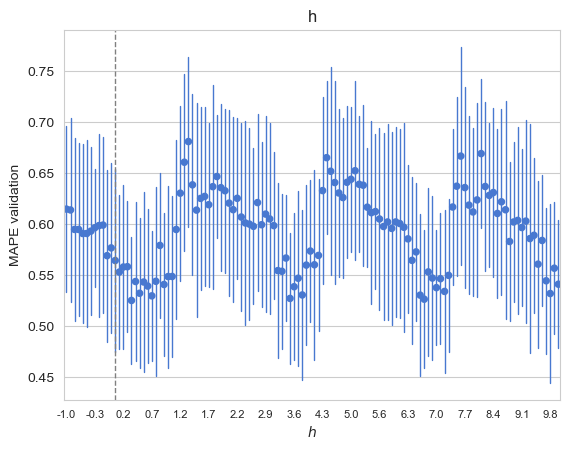

In [65]:
xaxis_column = 'ising_h'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['ftype', 'measaxes']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    # change_moi = {'ftype': 0}, 
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    # cutoff = 30,
)

df[xaxis_column] = df[xaxis_column].astype(float)
    



ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    linestyles='none',
    hue=hue,
    dodge=.1,
    errorbar = errorbar_type, 
    errwidth=1,
    markers='.',
    # markers='x',
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ticks = [*range(len(df[xaxis_column].unique()))]
labels = [f'{_c:.1f}' for _c in df[xaxis_column].unique()]
xpos = labels.index('0.1')
ticks, labels = plotting.sparse_ticks(ticks, labels, 20)
ax.set_xticks(ticks, labels, size=8)

# vertical line at 1
ax.set_ylim(ax.get_ylim())
ax.axvline(xpos, color='gray', linestyle='--', linewidth=1)

ax.set_title('h')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel(r'$h$')
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

## number of training episodes (nepisodes)

- same rseed insures that validation episodes are always the same 15 episodes
- training episodes are always the same as the previous + some more episodes

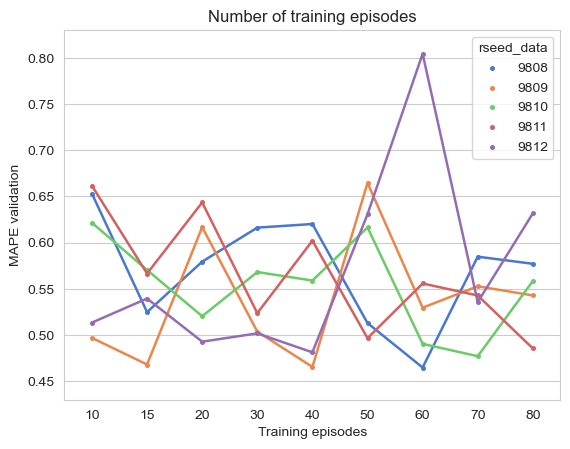

In [66]:
xaxis_column = 'nepisodes'
hue_columns = ['rseed_data']

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    # keep_columns = ['rseed_data'],
    select_values_range={'nepisodes': [5, 95], 'rseed_data': [9807, 9813]},
)


ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    hue=hue,
    dodge=0,
    errorbar = errorbar_type, 
    # errwidth=1.,
    errwidth=0.,
    linestyles = '-',
    linewidth=1,
    # markers='^',
    markers='.',
    markersize=2,
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

# if hue is not None: 
#     legend = plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
# legend.get_frame().set_linewidth(0.0)

# ax.set_xticks([''])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Training episodes')

# ax.autoscale()
ax.set_ylim(.43, .83)

ax.set_title('Number of training episodes')
# plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

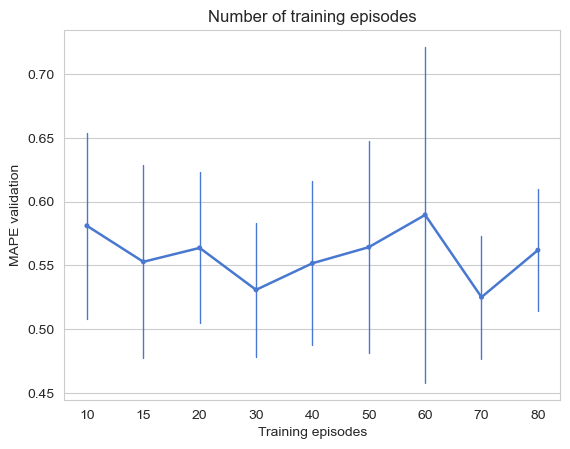

In [67]:
xaxis_column = 'nepisodes'

hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    # select_values_range={'nepisodes': [5, 95], 'rseed_data': [9807, 9813]},
    select_values_range={'nepisodes': [5, 95]},
)


ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    hue=hue,
    dodge=0,
    errorbar = errorbar_type, 
    errwidth=1.,
    linestyles = '-',
    # markers='^',
    markers='.',
    markersize=2,
    linewidth=1,
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

# if hue is not None: 
#     legend = plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
# legend.get_frame().set_linewidth(0.0)

# ax.set_xticks([''])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Training episodes')

ax.autoscale()
# ax.set_ylim(.43, .83)

ax.set_title('Number of training episodes')
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

# Restarting vs Rewinding: lookback

comparison with restarting

xoffset 51.0
[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49]
[1, 4, 7, 10, 13, 16, 19, 22, 25, 28, 31, 34, 37, 40, 43, 46, 49, 51.0]
['1', '4', '7', '10', '13', '16', '19', '22', '25', '28', '31', '34', '37', '40', '43', '46', '49', 'inf']


/Users/andreas-burger/RLCode/quantum-reinforcement-learning/qrc_surrogate/experiments/plotting/plotting.py:156: UserWarning: You passed a edgecolor/edgecolors ([(0.9333333333333333, 0.5215686274509804, 0.2901960784313726)]) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


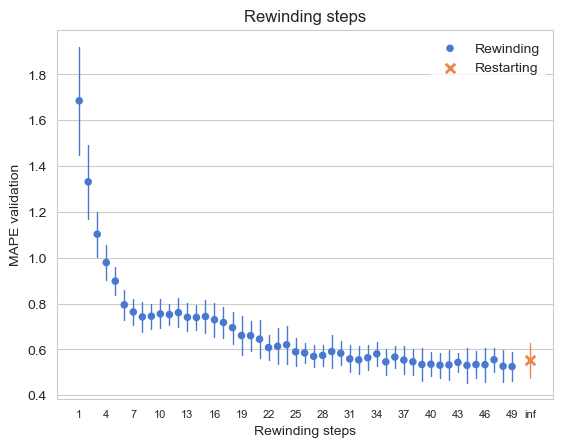

In [68]:
xaxis_column = 'lookback'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['ftype', 'measaxes']
hue_columns = ['restarting']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    change_moi = {'ftype': 3, 'restarting': False, 'lookback_max': False},
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    # cutoff = 30,
)

df[xaxis_column] = df[xaxis_column].astype(int)

# plot primary
ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    linestyles='none',
    dodge=.1,
    errorbar = errorbar_type, 
    errwidth=1,
    markers='.',
    # hue=hue,
    label='Rewinding',
    xpos=True,
)

#####################################################################

xlim = ax.get_xlim()
ylim = ax.get_ylim()

colors = sns.color_palette().as_hex()
df_secondary, _ = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    change_moi = {'ftype': 3, 'restarting': True},
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
)


xoffset = float(np.max(df[xaxis_column].unique()) + 2)
print('xoffset', xoffset)

df_secondary[xaxis_column] = xoffset
ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df_secondary, 
    linestyles='none',
    # hue=hue,
    dodge=.1,
    errorbar = errorbar_type, 
    errwidth=1,
    ax=ax,
    color=colors[1],
    markers='x',
    label='Restarting',
    xpos=True,
    # xoffset=xoffset,
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Rewinding steps')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Rewinding steps')
ticks = df[xaxis_column].unique()
labels = [str(_c) for _c in df[xaxis_column].unique()]
ticks, labels = plotting.sparse_ticks(ticks, labels, 20)
print(ticks)
ticks.append(xoffset)
labels.append('inf')
print(ticks)
print(labels)
ax.set_xticks(ticks, labels, size=8)

ax.autoscale()

legend = ax.legend(frameon=True)
legend.get_frame().set_linewidth(0.0)

plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

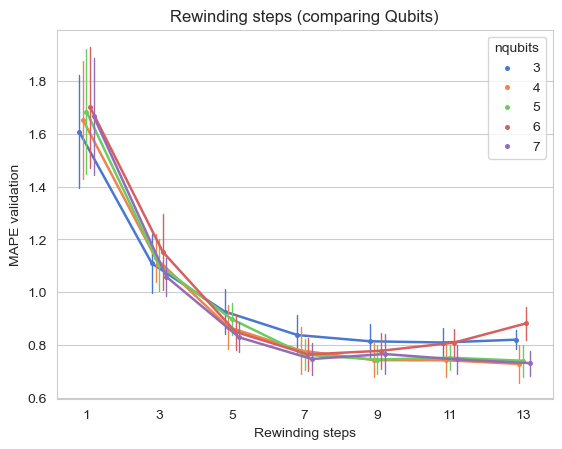

In [69]:
xaxis_column = 'lookback'

hue_columns = []
hue_columns = ['nqubits']

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    change_moi = {'restarting': False, 'lookback_max': False},
    keep_columns = ['rseed_data'],
    # select_values_range={'lookback': [0, 16]},
    select_values={'lookback': [1, 3, 5, 7, 9, 11, 13]},
    # cutoff = 30,
)


# plot primary
ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    hue=hue,
    # palette=colors_sequential,
    dodge=.2,
    errorbar = errorbar_type, 
    errwidth=1,
    # errwidth=0.,
    # linestyles='none',
    linestyles = '-',
    linewidth=1,
    markers='.',
    markersize=2,
    # label='Rewinding',
    # xpos=True,
)


h, l = ax.get_legend_handles_labels()

#####################################################################

# colors = sns.color_palette().as_hex()
# df_secondary, hue_secondary = plotting.get_relevant_dataframe(
#     f, model_of_interest, data_of_interest,
#     xaxis_column = xaxis_column,
#     change_moi = {'ftype': 3, 'restarting': True},
#     hue_columns = hue_columns,
#     keep_columns = ['rseed_data'],
# )


# xoffset = float(np.max(df[xaxis_column].unique()) + 2)
# df_secondary[xaxis_column] = xoffset
# ax = plotting.better_pointplot(
#     x = xaxis_column, y = ymetric, data = df_secondary, 
#     linestyles='none',
#     hue=hue_secondary,
#     palette=colors_sequential, # colors_sequential_secondary
#     # color=colors[1],
#     dodge=.2,
#     errorbar = errorbar_type, 
#     errwidth=1,
#     ax=ax,
#     markers='x',
#     label='Restarting',
#     xpos=True,
#     # xoffset=xoffset,
# )

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Rewinding steps (comparing Qubits)')
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Rewinding steps')

# ticks = df[xaxis_column].unique()
# labels = [str(_c) for _c in df[xaxis_column].unique()]
# ticks, labels = plotting.sparse_ticks(ticks, labels, 20)
# ticks.append(xoffset)
# labels.append('inf')
# ax.set_xticks(ticks, labels, size=8)

ax.autoscale()

# if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
# legend = ax.legend(h, l)
# legend.get_frame().set_linewidth(0.0)

# plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

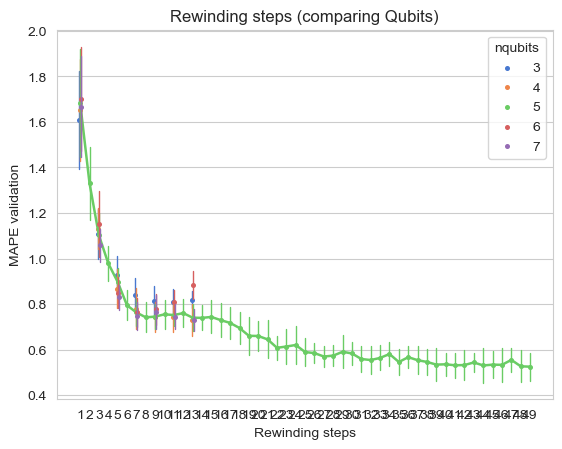

In [70]:
xaxis_column = 'lookback'

hue_columns = []
hue_columns = ['nqubits']

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    change_moi = {'restarting': False, 'lookback_max': False},
    keep_columns = ['rseed_data'],
    # select_values_range={'lookback': [0, 16]},
    # cutoff = 30,
)


# plot primary
ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    hue=hue,
    # palette=colors_sequential,
    dodge=.2,
    errorbar = errorbar_type, 
    errwidth=1,
    # errwidth=0.,
    # linestyles='none',
    linestyles = '-',
    linewidth=1,
    markers='.',
    markersize=2,
    # label='Rewinding',
    # xpos=True,
)


h, l = ax.get_legend_handles_labels()

#####################################################################

# colors = sns.color_palette().as_hex()
# df_secondary, hue_secondary = plotting.get_relevant_dataframe(
#     f, model_of_interest, data_of_interest,
#     xaxis_column = xaxis_column,
#     change_moi = {'ftype': 3, 'restarting': True},
#     hue_columns = hue_columns,
#     keep_columns = ['rseed_data'],
# )


# xoffset = float(np.max(df[xaxis_column].unique()) + 2)
# df_secondary[xaxis_column] = xoffset
# ax = plotting.better_pointplot(
#     x = xaxis_column, y = ymetric, data = df_secondary, 
#     linestyles='none',
#     hue=hue_secondary,
#     palette=colors_sequential, # colors_sequential_secondary
#     # color=colors[1],
#     dodge=.2,
#     errorbar = errorbar_type, 
#     errwidth=1,
#     ax=ax,
#     markers='x',
#     label='Restarting',
#     xpos=True,
#     # xoffset=xoffset,
# )

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Rewinding steps (comparing Qubits)')
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Rewinding steps')

# ticks = df[xaxis_column].unique()
# labels = [str(_c) for _c in df[xaxis_column].unique()]
# ticks, labels = plotting.sparse_ticks(ticks, labels, 20)
# ticks.append(xoffset)
# labels.append('inf')
# ax.set_xticks(ticks, labels, size=8)

ax.autoscale()

# if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
# legend = ax.legend(h, l)
# legend.get_frame().set_linewidth(0.0)

# plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

# Number of shots

/Users/andreas-burger/RLCode/quantum-reinforcement-learning/qrc_surrogate/experiments/plotting/plotting.py:156: UserWarning: You passed a edgecolor/edgecolors ([(0.9333333333333333, 0.5215686274509804, 0.2901960784313726)]) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


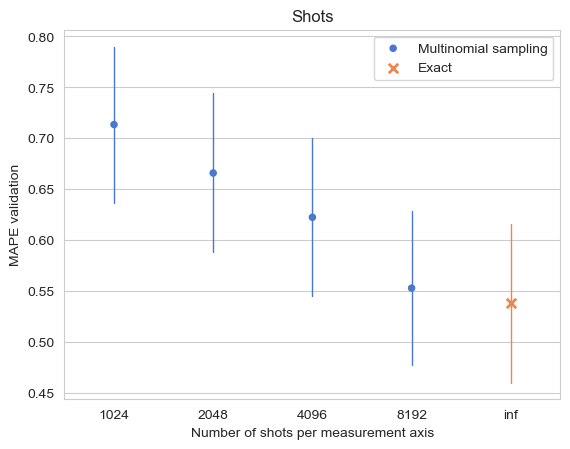

In [71]:
xaxis_column = 'shots'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['ftype', 'measaxes']
hue_columns = ['restarting']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    change_moi = {'ftype': 3, 'sim_sampling': 'multinomial'},
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    # cutoff = 30,
)

# sort
df[xaxis_column] = df[xaxis_column].astype(int)

# plot primary
ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    linestyles='none',
    dodge=.1,
    errorbar = errorbar_type, 
    errwidth=1,
    # hue=hue,
    markers='.',
    label='Multinomial sampling',
)

#####################################################################

xlim = ax.get_xlim()
ylim = ax.get_ylim()

colors = sns.color_palette().as_hex()
df_secondary, _ = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    change_moi = {'ftype': 3, 'sim_sampling': 'exact'},
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
)

_x_pos_secondary = len(df[xaxis_column].unique())

# _x_pos_secondary = -1
# df_secondary[xaxis_column] = _x_pos_secondary
ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df_secondary, 
    linestyles='none',
    # hue=hue,
    dodge=.1,
    errorbar = errorbar_type, 
    errwidth=1,
    ax=ax,
    color=colors[1],
    markers='x',
    label='Exact',
    xoffset=_x_pos_secondary,
)

xlim = [min(xlim[0], ax.get_xlim()[0]), max(xlim[1], ax.get_xlim()[1])+1]
ylim = [min(ylim[0], ax.get_ylim()[0]), max(ylim[1], ax.get_ylim()[1])]

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Shots')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('Number of shots per measurement axis')
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xticks(
    [*range(len(df[xaxis_column].unique())), _x_pos_secondary],
    # [*df[xaxis_column].unique(), _x_pos_secondary],
    [*[str(_c) for _c in df[xaxis_column].unique()], 'inf'],
)
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')

# ax.set_xscale('log')

plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
ax.legend()
plt.show()

# Noiselevels

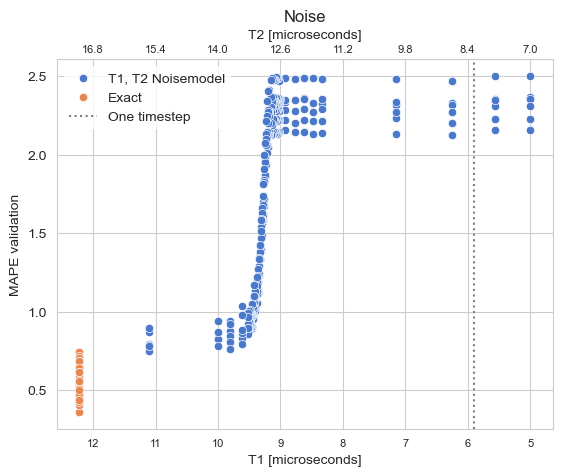

In [72]:
xaxis_column = 't1'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['ftype', 'measaxes']
hue_columns = ['restarting']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    change_moi = {'ftype': 3, 'sim': 'thermal'},
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    # cutoff = 30,
)

# sort
df[xaxis_column] = df[xaxis_column].astype(float)
df = df.sort_values(xaxis_column)

df = plotting.df_select_values_range(df, xaxis_column, 0, 12)

# plot primary
ax = sns.scatterplot(
    x = xaxis_column, y = ymetric, data = df, 
    hue=hue,
    label='T1, T2 Noisemodel',
)

################################
colors = sns.color_palette().as_hex()
df_secondary, _ = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column=xaxis_column,
    change_moi = {'ftype': 3, 'sim': 'aer_simulator'},
    keep_columns = ['rseed_data'],
)

# _x_pos_secondary = len(df[xaxis_column].unique())
_x_pos_secondary = max(df[xaxis_column].unique()) + abs(df[xaxis_column].unique()[-1] - df[xaxis_column].unique()[-2])
df_secondary[xaxis_column] = _x_pos_secondary
# df_secondary = df_secondary[df_secondary['restarting'] == True]
# df_secondary = df_secondary.groupby('rseed_data').mean().reset_index()
ax = sns.scatterplot(
    x = xaxis_column, y = ymetric, data = df_secondary, 
    hue=hue,
    label='Exact',
    markers='x',
    ax=ax,
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Noise')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('T1 [microseconds]')
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')

# 5.9 = time of circuit for one timestep
ax.set_ylim(ax.get_ylim())
ax.vlines(x = [5.9], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dotted', colors='gray', label='One timestep')
# ax.vlines(x = [5.9*2], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed', colors='gray', label='Two timesteps')

# noiseless as horizontal line

# secax = ax.secondary_xaxis('top', functions=(lambda x: x*7/5, lambda x: x*5/7))
secax = ax.secondary_xaxis('top')
secax.tick_params(width=0, length=0)
secax.set_xlabel('T2 [microseconds]')

# secax.invert_xaxis()
ax.invert_xaxis()

# secax.set_xscale('log')
# ax.set_xscale('log')

ticks_all = [_x_pos_secondary] + list(df[xaxis_column].unique())
labels_t1 = ['inf', *[f'{_c:.1f}' for _c in df[xaxis_column].unique()]]
labels_t2 = ['inf', *[f'{_c*7/5:.1f}' for _c in df[xaxis_column].unique()]]
ticks, labels_t1 = plotting.sparse_ticks(ticks_all, labels_t1, 20)
ticks, labels_t2 = plotting.sparse_ticks(ticks_all, labels_t2, 20)
# ax.set_xticks(ticks, labels_t1, size=8) 
# secax.set_xticks(ticks, labels_t2, size=8)
ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), size=8)
# secax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), size=8)
secax.set_xticks(ax.get_xticks(), [f'{float(_t.get_text())*7/5:.1f}' for _t in ax.get_xticklabels()], size=8)

ax.autoscale(axis="x", tight=False)

legend = ax.legend(frameon=True)
legend.get_frame().set_linewidth(0.0)
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}_all.svg')
plt.show()

# Time for Ising: 5.85 [microseconds]
# T1 when results detirioate: 9 - 9.5 [microseconds]
# T2 when results detirioate: 13 [microseconds]

_x_pos_secondary 12.222222222222221


/Users/andreas-burger/RLCode/quantum-reinforcement-learning/qrc_surrogate/experiments/plotting/plotting.py:156: UserWarning: You passed a edgecolor/edgecolors ([(0.9333333333333333, 0.5215686274509804, 0.2901960784313726)]) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


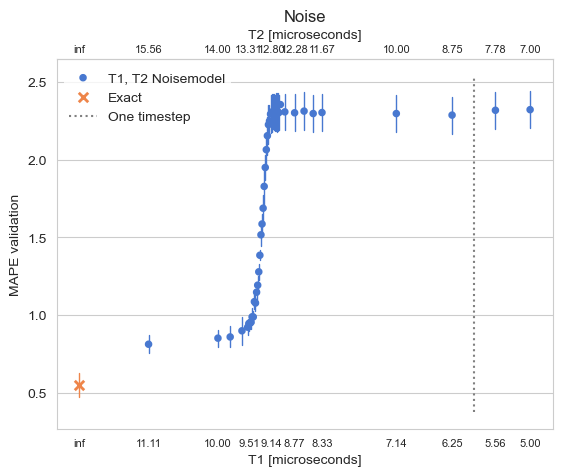

In [73]:
xaxis_column = 't1'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['ftype', 'measaxes']
hue_columns = ['restarting']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    change_moi = {'ftype': 3, 'sim': 'thermal'},
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    # cutoff = 30,
)

# sort
df[xaxis_column] = df[xaxis_column].astype(float)
df = df.sort_values(xaxis_column)

xmin, xmax = 0, 12
df = plotting.df_select_values_range(df, xaxis_column, xmin, xmax)

# plot primary
ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    linestyles='none',
    dodge=.1,
    errorbar = errorbar_type, 
    errwidth=1,
    # hue=hue,
    label='T1, T2 Noisemodel',
    markers='.',
    xpos=True,
)

#####################################################################

colors = sns.color_palette().as_hex()
df_secondary, _ = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    change_moi = {'ftype': 3, 'sim': 'aer_simulator'},
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
)

xsort = sorted(df[xaxis_column].unique())
_x_pos_secondary = xsort[-1] + abs(xsort[-1] - xsort[-2])
df_secondary[xaxis_column] = _x_pos_secondary
print('_x_pos_secondary', _x_pos_secondary)
ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df_secondary, 
    linestyles='none',
    # hue=hue,
    dodge=.1,
    errorbar = errorbar_type, 
    errwidth=1,
    ax=ax,
    color=colors[1],
    markers='x',
    label='Exact',
    xpos=True,
)


ax.set_title('Noise')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('T1 [microseconds]')
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')

# 5.9 = time of circuit for one timestep
ax.set_ylim(ax.get_ylim())
ax.vlines(x = [5.9], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dotted', colors='gray', label='One timestep')
# ax.vlines(x = [5.9*2], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed', colors='gray', label='Two timesteps')
# ax.margins(.1)
ax.autoscale()

# noiseless as horizontal line

# secax = ax.secondary_xaxis('top', functions=(lambda x: x*7/5, lambda x: x*5/7))
secax = ax.secondary_xaxis('top')
secax.tick_params(width=0, length=0)
secax.set_xlabel('T2 [microseconds]')

# secax.invert_xaxis()
ax.invert_xaxis()

# secax.set_xscale('log')
# ax.set_xscale('log')

ticks_all = [_x_pos_secondary, *list(df[xaxis_column].unique())]
labels_t1 = ['inf', *[f'{_c:.2f}' for _c in df[xaxis_column].unique()]]
labels_t2 = ['inf', *[f'{_c*7/5:.2f}' for _c in df[xaxis_column].unique()]]
ticks, labels_t1 = plotting.sparse_ticks(ticks_all, labels_t1, 20)
ticks, labels_t2 = plotting.sparse_ticks(ticks_all, labels_t2, 20)
ax.set_xticks(ticks, labels_t1, size=8) 
secax.set_xticks(ticks, labels_t2, size=8)

legend = ax.legend(frameon=True)
legend.get_frame().set_linewidth(0.0)
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}_all_avg.svg')
plt.show()

_x_pos_secondary 9.541915625565816


/Users/andreas-burger/RLCode/quantum-reinforcement-learning/qrc_surrogate/experiments/plotting/plotting.py:156: UserWarning: You passed a edgecolor/edgecolors ([(0.9333333333333333, 0.5215686274509804, 0.2901960784313726)]) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y,


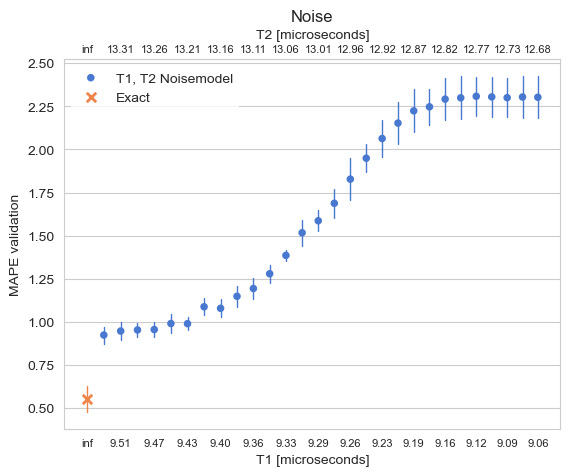

In [74]:
xaxis_column = 't1'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['ftype', 'measaxes']
hue_columns = ['restarting']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    change_moi = {'ftype': 3, 'sim': 'thermal'},
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    # cutoff = 30,
)




# sort
df[xaxis_column] = df[xaxis_column].astype(float)
df = df.sort_values(xaxis_column)

xmin, xmax = 0, 12
xmin, xmax = 9.05, 9.55
df = plotting.df_select_values_range(df, xaxis_column, xmin, xmax)

# plot primary
ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    linestyles='none',
    dodge=.1,
    errorbar = errorbar_type, 
    errwidth=1,
    # hue=hue,
    label='T1, T2 Noisemodel',
    xpos=True,
    markers='.',
)

#####################################################################

colors = sns.color_palette().as_hex()
df_secondary, _ = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    change_moi = {'ftype': 3, 'sim': 'aer_simulator'},
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
)

xsort = sorted(df[xaxis_column].unique())
_x_pos_secondary = xsort[-1] + abs(xsort[-1] - xsort[-2])
df_secondary[xaxis_column] = _x_pos_secondary
print('_x_pos_secondary', _x_pos_secondary)
ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df_secondary, 
    linestyles='none',
    # hue=hue,
    dodge=.1,
    errorbar = errorbar_type, 
    errwidth=1,
    ax=ax,
    color=colors[1],
    markers='x',
    label='Exact',
    xpos=True,
)


ax.set_title('Noise')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('T1 [microseconds]')
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')

# 5.9 = time of circuit for one timestep
ax.set_ylim(ax.get_ylim())
# ax.vlines(x = [5.9], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dotted', colors='gray', label='One timestep')
# ax.vlines(x = [5.9*2], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed', colors='gray', label='Two timesteps')
# ax.margins(.1)
ax.autoscale()

# noiseless as horizontal line

# secax = ax.secondary_xaxis('top', functions=(lambda x: x*7/5, lambda x: x*5/7))
secax = ax.secondary_xaxis('top')
secax.tick_params(width=0, length=0)
secax.set_xlabel('T2 [microseconds]')

# secax.invert_xaxis()
ax.invert_xaxis()

# secax.set_xscale('log')
# ax.set_xscale('log')

ticks_all = [_x_pos_secondary, *list(df[xaxis_column].unique())]
labels_t1 = ['inf', *[f'{_c:.2f}' for _c in df[xaxis_column].unique()]]
labels_t2 = ['inf', *[f'{_c*7/5:.2f}' for _c in df[xaxis_column].unique()]]
ticks, labels_t1 = plotting.sparse_ticks(ticks_all, labels_t1, 20)
ticks, labels_t2 = plotting.sparse_ticks(ticks_all, labels_t2, 20)
ax.set_xticks(ticks, labels_t1, size=8) 
secax.set_xticks(ticks, labels_t2, size=8)

legend = ax.legend(frameon=True)
legend.get_frame().set_linewidth(0.0)
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}_jump_avg.svg')
plt.show()

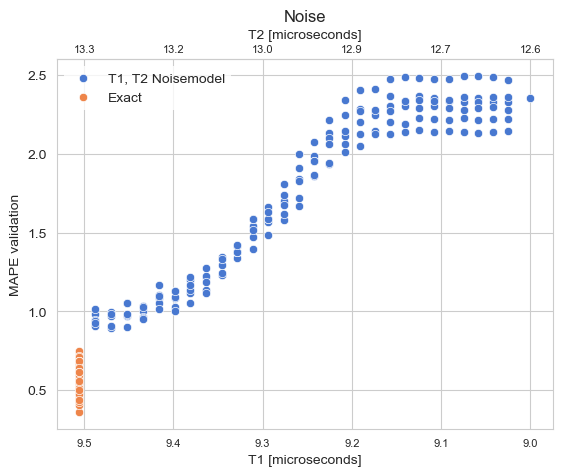

In [75]:
xaxis_column = 't1'

hue_columns = ['qctype', 'measaxes']
hue_columns = ['ftype', 'measaxes']
hue_columns = ['restarting']
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    change_moi = {'ftype': 3, 'sim': 'thermal'},
    hue_columns = hue_columns,
    keep_columns = ['rseed_data'],
    # cutoff = 30,
)




# sort
df[xaxis_column] = df[xaxis_column].astype(float)
df = df.sort_values(xaxis_column)

# only take values in this list
df = plotting.df_select_values_range(df, xaxis_column, 9, 9.5)
# df = select_values(
#     df, xaxis_column, 
#     [0., 1., 0.1, .5, 2., 3., 4., 5.,  6., 7., 8., 9., 10.]
# )

# plot primary
ax = sns.scatterplot(
    x = xaxis_column, y = ymetric, data = df, 
    hue=hue,
    label='T1, T2 Noisemodel',
)

################################
colors = sns.color_palette().as_hex()
df_secondary, _ = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column=xaxis_column,
    change_moi = {'ftype': 3, 'sim': 'aer_simulator'},
    keep_columns = ['rseed_data'],
)



_x_pos_secondary = max(df[xaxis_column].unique()) + abs(df[xaxis_column].unique()[-1] - df[xaxis_column].unique()[-2])
df_secondary[xaxis_column] = _x_pos_secondary

ax = sns.scatterplot(
    x = xaxis_column, y = ymetric, data = df_secondary, 
    hue=hue,
    label='Exact',
    markers='x',
    ax=ax,
)

# ax = plotting.show_average_lines(ax, df, hue_columns, ymetric)

ax.set_title('Noise')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_ylabel(ymetric.split('_')[0].upper() + ' validation')
ax.set_xlabel('T1 [microseconds]')
ax.set_ylim(ax.get_ylim())
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')

# 5.9 = time of circuit for one timestep
# ax.vlines(x = [/5.9], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dotted', colors='gray', label='One timestep')
# ax.vlines(x = [/(5.9*2)], ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linestyles='dashed', colors='gray', label='Two timesteps')

secax = ax.secondary_xaxis('top')
secax.tick_params(width=0, length=0)
secax.set_xlabel('T2 [microseconds]')

# secax.invert_xaxis()
ax.invert_xaxis()

# secax.set_xscale('log')
# ax.set_xscale('log')

ticks_all = [_x_pos_secondary] + list(df[xaxis_column].unique())
labels_t1 = ['inf', *[f'{_c:.1f}' for _c in df[xaxis_column].unique()]]
labels_t2 = ['inf', *[f'{_c*7/5:.1f}' for _c in df[xaxis_column].unique()]]
# labels_t1 = ['inf', *[f'{int(50/_c)}' for _c in df[xaxis_column].unique()]]
ticks, labels_t1 = plotting.sparse_ticks(ticks_all, labels_t1, 20)
ticks, labels_t2 = plotting.sparse_ticks(ticks_all, labels_t2, 20)

# ax.set_xticks(ticks, labels_t1, size=8) 
# secax.set_xticks(ticks, labels_t2, size=8)

ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), size=8)
secax.set_xticks(ax.get_xticks(), [f'{float(_t.get_text())*7/5:.1f}' for _t in ax.get_xticklabels()], size=8)

ax.autoscale(axis='x')

legend = ax.legend(frameon=True)
legend.get_frame().set_linewidth(0.0)
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}_jump.svg')
plt.show()

# Time for Ising: 5.85 [microseconds]
# T1 when results detirioate: 9 - 9.5 [microseconds]
# T2 when results detirioate: 13 [microseconds]

# Error Source

Here we show that the primary error source is error accumulation (drift) over time.
Error accumulates because the model takes in it's own previous prediction as input, and with it any error in previous predictions.

Generalization

training data = validation data
-> accumulating error / drift because of recurrent structure 
(use past outputs as future inputs)
train_equal_val=True

training data = validation data, and using true past outputs as inputs
-> irreducable error due to noise or statistical fluctuations (e.g. in circuit compilation or fitter)
train_equal_val=True, use_true_y_in_val=True

using true past outputs as inputs (but on different training / validation data)
-> model error (ability to predict next step)
use_true_y_in_val=True


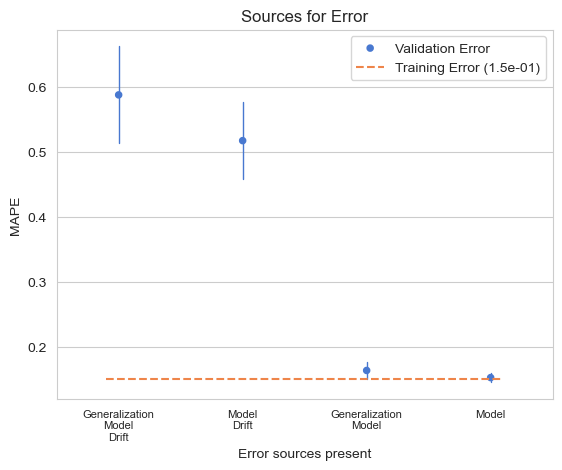

In [76]:
xaxis_column = 'rseed_data'
hue_columns = []

df, hue = plotting.get_relevant_dataframe(
    f, model_of_interest, data_of_interest,
    xaxis_column = xaxis_column,
    hue_columns = hue_columns,
    keep_columns = ['train_equal_val', 'use_true_y_in_val'],
    # change_moi = {'shots': 8192},
    # cutoff = 50,
)

xaxis_column = 'error_source'

df['error_source'] = 0
df.loc[df['use_true_y_in_val'] == True, 'error_source'] = 2
df.loc[df['train_equal_val'] == True, 'error_source'] += 1
df.drop(['use_true_y_in_val', 'train_equal_val'], axis=1)



# draw training error
# ax = plotting.better_pointplot(
#     x = xaxis_column, y = ymetric_train, data = df, 
#     # label = f'{qctype}',
#     hue=hue,
#     dodge=.1,
#     errorbar = errorbar_type, 
#     errwidth=1,
#     # linestyles='None',
#     # markers='x',
#     linestyles='-',
#     markers='none',
#     color=colors[1],
#     label='Training',
# )

ax = plotting.better_pointplot(
    x = xaxis_column, y = ymetric, data = df, 
    # label = f'{qctype}',
    hue=hue,
    dodge=.1,
    linestyles='None',
    errorbar = errorbar_type, 
    errwidth=1,
    markers='.',
    label='Validation Error',
)

mse_train = df[ymetric_train].mean()
# ax.axhline(y=mse_train, linestyle='--', color=colors[1], label='Training Error')
ax.axhline(y=mse_train, xmin=0.1, xmax=.9, linestyle='--', color=colors[1], label=f'Training Error ({mse_train:.1e})')


ax.set_title('Sources for Error')
if hue is not None: plt.legend(title=''.join([c + ', ' for c in hue_columns])[:-2])
ax.set_xticks([0, 1, 2, 3], ['Generalization\nModel\nDrift', 'Model\nDrift', 'Generalization\nModel', 'Model'], size=8)
ax.set_ylabel(ymetric.split('_')[0].upper())
ax.set_xlabel('Error sources present')
ax.legend()
# h, l = ax.get_legend_handles_labels()
# ax.legend(handles=ax.get_legend_handles_labels()[0], labels=[''], title='title')
plt.savefig(f'{plot_path}/{model.model_name}_{fname_data}_{xaxis_column}.svg')
plt.show()

# Why are some ising circuits performing better than others?

In [77]:
from src.circuits import ising_circuit

In [78]:
# for rseed in [2686, 2685, 9369]:
#     circ = ising_circuit(nqubits=5, rseed=rseed)

#     gates = {index:{'name': gate[0].name, 'params': gate[0].params[0]} for index, gate in enumerate(circ)}

#     df = pd.DataFrame(gates).T

#     avg = df.groupby(['name']).mean()
#     std = df.groupby(['name']).std()
#     # median = df.groupby(['name']).median()

#     plt.scatter([0, 1, 2, 3], [avg, std], label=rseed)
#     plt.scatter([0, 1, 2, 3, 4, 5], [avg, std, median], label=rseed)
#     plt.xticks(ticks=[0, 1, 2, 3], labels=['mean Rxx', 'mean Rz', 'std Rxx', 'std Rz'])
# plt.legend(title='rseed (QRewindingRC)', labels=['2686 (worst)', '2685 (middle)', '9369 (best)'])
# ax.set_title('How gate parameters vary for different rseeds')
# plt.savefig(f'{plot_path}/ising_circuit_gates_rseeds.svg')
# plt.show()

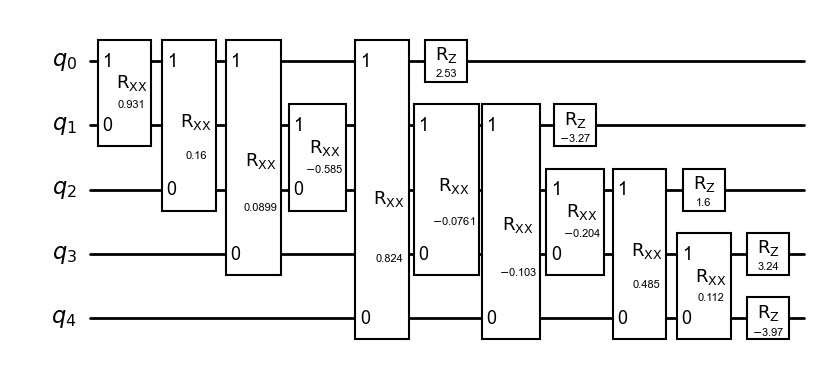

In [79]:
qc_optimal = ising_circuit(nqubits=5, rseed=9369)

qc_optimal.draw('mpl', style='bw')
qc_optimal.draw('mpl', filename=f'{plot_path}/ising_circuit.svg', style='bw')

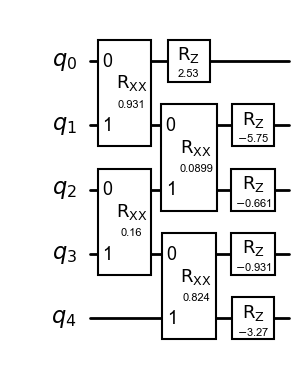

In [80]:
qc_optimal = ising_circuit(nqubits=5, rseed=9369, mode='nn')

qc_optimal.draw('mpl', style='bw')
# qc_optimal.draw('mpl', filename=f'{plot_path}/ising_nn_circuit.svg', style='bw')

# time it takes for one circuit to run


In [81]:
from src.noisemodel import thermal_model

nqubits = 5
sim_method = 'density_matrix'

noise = 1.
noise_model = thermal_model(
    nqubits=nqubits, 
    t1_mean=50e3/noise,
    t2_mean=70e3/noise,
    verbose = True,
)
backend = AerSimulator(method = sim_method, noise_model = noise_model)

qc_noisy = transpile(qc_optimal, backend)

qc_noisy.draw()
# in noisy sim i neglect time for resets and measurements!
# u3 doesnt matter when parallel to cx
# rz is virtual and for free
# u2, cx (3)
# cx (4)
# cx (6)
# cx (4)
# cx (2)
# cx, u3
# -> cx*19 + u2 + u3 = 300*19 + 50 + 100
# -> 5850 [nanoseconds] = 5.85 [microseconds]

T1 mean 5.000000e+07
[50001257.30221093 49998678.95136709 50006404.22650443 50001049.00117153
 49994643.30626839]
T2 mean 7.000000e+07
[70003615.9505491  70013040.0004513  70009470.80963129 69992962.64764193
 69987345.78528954]


global phase: 4.0386
     ┌─────────┐                                   ┌───────────────────┐»
q_0: ┤ U2(0,π) ├──■─────────────────────────────■──┤ U3(π/2,2.5296,-π) ├»
     ├─────────┤┌─┴─┐┌───────────────────────┐┌─┴─┐└───────────────────┘»
q_1: ┤ U2(0,π) ├┤ X ├┤ Rz(0.931111105679366) ├┤ X ├──────────■──────────»
     ├─────────┤└───┘└───────────────────────┘└───┘        ┌─┴─┐        »
q_2: ┤ U2(0,π) ├──■─────────────────────────────■──────────┤ X ├────────»
     ├─────────┤┌─┴─┐ ┌──────────────────────┐┌─┴─┐        └───┘        »
q_3: ┤ U2(0,π) ├┤ X ├─┤ Rz(0.15957384579693) ├┤ X ├──────────■──────────»
     ├─────────┤└───┘ └──────────────────────┘└───┘        ┌─┴─┐        »
q_4: ┤ U2(0,π) ├───────────────────────────────────────────┤ X ├────────»
     └─────────┘                                           └───┘        »
«                                                          
«q_0: ─────────────────────────────────────────────────────
«                                    ┌────────────────────┐
«q_1: ───────────────────────────■───┤ U3(π/2,0.53362,-π) ├
«     ┌───────────────────────┐┌─┴─┐┌┴────────────────────┤
«q_2: ┤ Rz(0.089852347478709) ├┤ X ├┤ U3(π/2,-0.66066,-π) ├
«     └───────────────────────┘└───┘├─────────────────────┤
«q_3: ───────────────────────────■──┤ U3(π/2,-0.93125,-π) ├
«     ┌───────────────────────┐┌─┴─┐└┬───────────────────┬┘
«q_4: ┤ Rz(0.824293662956538) ├┤ X ├─┤ U3(π/2,3.0179,-π) ├─
«     └───────────────────────┘└───┘ └───────────────────┘

# Noisy evolution

In [82]:
# data = DataSource(**data_of_interest)
# model_of_interest1 = deepcopy(model_of_interest)
# model_of_interest1['sim'] = 'thermal'
# model_of_interest1['t1'] = 9
# rnn = QRewindingStatevectorRC(**model_of_interest1)

# rnn.run(data)

# fig = rnn.plot_val()

In [83]:
# data = DataSource(**data_of_interest)
# model_of_interest1 = model_of_interest
# model_of_interest1['sim'] = 'thermal'
# model_of_interest1['t1'] = 10
# rnn = QRewindingStatevectorRC(**model_of_interest1)

# rnn.run(data)

# fig = rnn.plot_val()